# Pull Data




Grabbing WebIDs ...
WebID collection complete!
12:28:08: Sending API request... Chunk 1 of 1
12:28:09: Response recieved for 1 tags! (1.44)


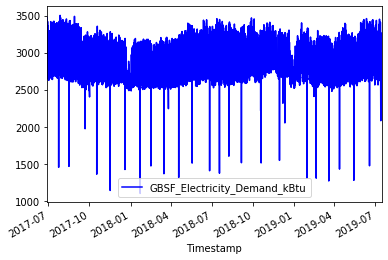

In [2]:
import json 
import pandas as pd
import datetime
from dateutil import parser
import os
import sys
from sklearn.preprocessing import MinMaxScaler
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.arima_model import ARIMA


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df.plot(color = 'blue')


#extract electricity data, rolling for more features (x) with elec(y) - make into df
#split into training + testing
#plot elec data split into training + testing
#use gridsearchcv to fit randomforest model
#evaluate accuracy, print, show predictions and actual elec data in plot
#refit randomforest to all data
#show all points and residuals
#get all residuals
#from there, extract outlier indexes
#show all residuals and outliers in third plot
#show original outliers in data in fourth plot, fifth is outliers removed

# Add New Variables

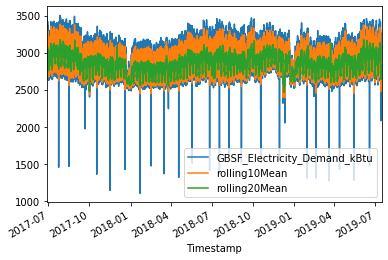

In [43]:
new = df.rolling(window = 10, min_periods = 1).mean()
new.columns = ['rolling10Mean']
new['rolling20Mean'] = df.rolling(window = 20, min_periods = 1).mean().iloc[:, 0]
merged = pd.merge(df, new, on = 'Timestamp')
merged = merged.dropna()
merged.plot()

# Split Data Into Training + Testing

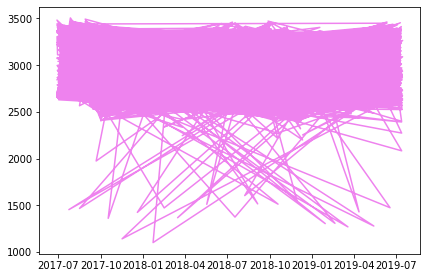

In [46]:
from sklearn.model_selection import train_test_split

merged.corr()
X = merged.iloc[:, [1, 2]]
y = merged.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#plot electricity training and testing
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train, color = 'violet')